## Jupyter notebook's kernel being crashing, let's continue here with the naive Bayes training

In [1]:
import numpy as np 
import pandas as pd
from nltk.corpus import stopwords 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [2]:
merged_df = pd.read_csv('merged_all_csv.csv')
merged_df['comment_cleaned'] = merged_df['comment_cleaned'].astype(str)
merged_df['comment_cleaned_lower'] = merged_df['comment_cleaned'].str.lower()
merged_df['label'] = np.where(merged_df['label'] == 'sarcasm', 0, 1)
X = merged_df['comment_cleaned_lower']
y = merged_df['label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((29751,), (12751,))

In [4]:
print(X_test[34464], y_test[34464])

if i saw this type of person in school i would bully them too 1


Everything is the same as in the previous notebook, let's go on

## Vectorizer + Naive Bayes pipeline

In [5]:
# Pipeline vectorizer + Naive Bayes
pipeline_naive_bayes = make_pipeline(
    CountVectorizer(), 
    MultinomialNB()
)

# Cross-validation
cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["recall"])
average_recall = cv_results["test_recall"].mean()
print("average recall is", np.round(average_recall,2))

cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["accuracy"])
average_accuracy = cv_results["test_accuracy"].mean()
print("average accuracy is", np.round(average_accuracy,2))

cv_results = cross_validate(pipeline_naive_bayes, X_train, y_train, cv = 5, scoring = ["precision"])
average_precision = cv_results["test_precision"].mean()
print("average precision is", np.round(average_precision,2))

average recall is 0.99
average accuracy is 0.92
average precision is 0.91


In [6]:
# Define the grid of parameters
parameters = {
    'countvectorizer__ngram_range': ((1,1), (2,2)),
    'multinomialnb__alpha': (0.1,1)
}

# Perform Grid Search
grid_search = GridSearchCV(
            pipeline_naive_bayes,
            parameters,
            scoring = "accuracy",
            cv = 5,
            n_jobs=-1,
            verbose=1)

grid_search.fit(X_train, y_train)

# Best score
print(f"Best Score = {grid_search.best_score_}")

# Best params
print(f"Best params = {grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score = 0.9324056319889744
Best params = {'countvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.1}


## Make a prediction 🔮

In [7]:
X_train[100:103]

20451    i think you are a big idiot.. i'm quoting emin...
6346     because no one ever gets laid off and has to t...
20636         i know that your husband can beat you the...
Name: comment_cleaned_lower, dtype: object

In [8]:
pipeline_naive_bayes.fit(X_train, y_train)
vec = CountVectorizer(stop_words='english')
y_pred_example = pipeline_naive_bayes.predict(X_train[100:103])

y_pred_example

array([1, 0, 1])

In [10]:
y_pred= pipeline_naive_bayes.predict(X_test)

## Check the accuracy score

In [11]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#(Here, y_test are the true class labels and y_pred are the predicted class labels in the test-set.)

Model accuracy score: 0.9278


In [12]:
#Now, let's compare the train-set and test-set accuracy to check for overfitting.

y_pred_train = pipeline_naive_bayes.predict(X_train)
y_pred_train

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9562


In [13]:
##Check for overfitting and underfitting

print('Training set score: {:.4f}'.format(pipeline_naive_bayes.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(pipeline_naive_bayes.score(X_test, y_test)))

Training set score: 0.9562
Test set score: 0.9278


The training-set accuracy score is 0.85 while the test-set accuracy to be 0.80. 
These two values are consistent, there is no sign of overfitting.

## Confusion matrix

Let's try to understand which label was confused by the model with which other label, let's see what are the true positives,
the true negatives, the false positives and the false negatives.

In [14]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[2345  807]
 [ 113 9486]]

True Positives(TP) =  2345

True Negatives(TN) =  9486

False Positives(FP) =  807

False Negatives(FN) =  113


<AxesSubplot:>

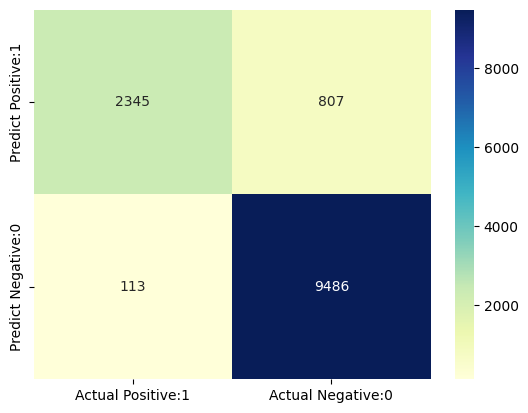

In [15]:
# visualizing confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<AxesSubplot:>

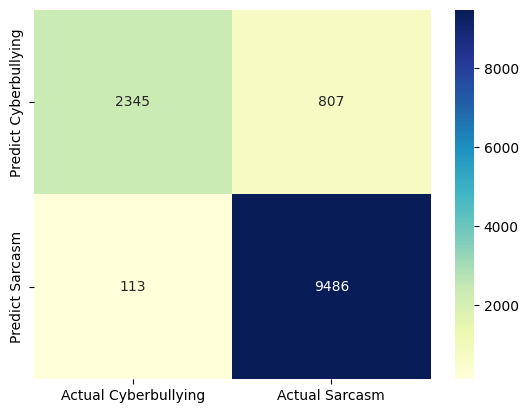

In [16]:
## Another confusion matrix with our labels, more understandable
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Cyberbullying', 'Actual Sarcasm'], 
                                 index=['Predict Cyberbullying', 'Predict Sarcasm'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

We have quiet high false positives (sarcastic comments predicted as cyberbullying). But the most important in our task is that we have very little number of false negatives (6), meaning bullying comments being classified as sarcasm.

## Making prediction on new sentences

In [17]:
# custom function
def my_prediction(my_sentence, model):
    prediction = pipeline_naive_bayes.predict([my_sentence])
    return prediction

my_sentence = "I HATE YOU dumb ... swear to god"
print(my_prediction(my_sentence, pipeline_naive_bayes))

[1]


In [18]:
my_sentence = "well yeah"
print(my_prediction(my_sentence, pipeline_naive_bayes))

[0]


## Saving the modified dataset as a new csv file

In [19]:
merged_df.to_csv('merged_all_modified_csv.csv')